# Initial Setup

## Import the required libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
from torch_geometric.data import Data
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
import torch.nn.functional as F
from torch_geometric.transforms import RandomLinkSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

## Set the Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Load the Dataset

In [3]:
features = pd.read_csv('features.csv')
features.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,unique_retweets,total_retweets,degree_centrality,partition
0,0.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,1.000000,1.0,1.0,1.0,2.0,176587.0
1,0.000000,0.0,0.003521,0.003521,0.003521,0.000000,0.003521,0.003521,0.000000,0.000000,...,0.003521,0.003521,0.000000,0.003521,0.003521,1.0,1.0,1.0,2.0,75.0
2,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,1.0,1.0,2.0,166285.0
3,0.000000,1.0,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,2.000000,2.0,1.0,1.0,2.0,96304.0
4,0.006667,0.0,0.000000,0.000000,0.000000,0.006667,0.006667,0.000000,0.006667,0.006667,...,0.006667,0.006667,0.006667,1.000000,0.006667,0.0,1.0,1.0,2.0,173.0


In [4]:
trainEdgeList = []
with open('train.txt') as inputFile:
    numNodes = int(inputFile.readline())
    for line in inputFile.readlines():
        src, dst, weight = map(int, line.split())
        trainEdgeList.append([src, dst, weight])
len(trainEdgeList)

1113811

In [5]:
trainEdgeDF = pd.DataFrame(trainEdgeList, columns = ['from', 'to', 'weight'])
trainEdgeDF.head()

,from,to,weight
0,701683,871966,1
1,729650,974012,1
2,93571,927327,1
3,339405,563090,1
4,1003443,652581,1


# Data Preparation

## Create Pytorch-Geometric Object

In [6]:
train_edge_index = torch.tensor((trainEdgeDF[['from', 'to']].values).T)
train_edge_weight = torch.tensor((trainEdgeDF[['weight']].values).T)

In [7]:
train_features = torch.tensor(np.array(features.values, dtype = np.float32), dtype = torch.float32)
train_features.shape, train_edge_index.shape, train_edge_weight.shape

(torch.Size([1563421, 25]), torch.Size([2, 1113811]), torch.Size([1, 1113811]))

In [8]:
data = Data(x = train_features, edge_index = train_edge_index, edge_attr = train_edge_weight)

## Prepare of Training, Validation and Testing Batches

In [9]:
transform = RandomLinkSplit(num_val = 0.1, num_test = 0.1, is_undirected=False, add_negative_train_samples = True, neg_sampling_ratio = 1)
train_data, val_data, test_data = transform(data)
train_data.edge_label.shape, val_data.edge_label.shape, test_data.edge_label.shape

(torch.Size([1782098]), torch.Size([222762]), torch.Size([222762]))

In [10]:
train_edges = train_data.edge_label_index.numpy().T
train_edges = pd.DataFrame(train_edges, columns = ['from', 'to'])
valid_edges = val_data.edge_label_index.numpy().T
valid_edges = pd.DataFrame(valid_edges, columns = ['from', 'to'])
test_edges = test_data.edge_label_index.numpy().T
test_edges = pd.DataFrame(test_edges, columns = ['from', 'to'])

In [13]:
train_labels = train_data.edge_label.numpy()
valid_labels = val_data.edge_label.numpy()
test_labels = test_data.edge_label.numpy()

In [14]:
def buildDF(edges, labels):
    _from, _to = edges['from'].values, edges['to'].values
    left, right = features.iloc[_from].reset_index(), features.iloc[_to].reset_index()
    left, right = left.drop(columns = ['index']), right.drop(columns = ['index'])
    left, right = left.add_suffix('_left'), right.add_suffix('_right')
    df = pd.concat([left, right], axis = 1)
    df['label'] = df.index.map(lambda x : labels[x])
    return df

train_df = buildDF(train_edges, train_labels)
valid_df = buildDF(valid_edges, valid_labels)
test_df = buildDF(test_edges, test_labels)

In [11]:
train_edges['label'] = train_edges.index.map(lambda x : train_labels[x])
train_edges.to_csv('train_edges.csv')
train_df.to_csv('train_edges_with_features.csv')
valid_edges['label'] = valid_edges.index.map(lambda x : valid_labels[x])
valid_edges.to_csv('valid_edges.csv')
valid_df.to_csv('valid_edges_with_features.csv')
test_edges['label'] = test_edges.index.map(lambda x : test_labels[x])
test_edges.to_csv('test_edges.csv')
test_df.to_csv('test_edges')

In [13]:
train_X, train_y = train_df.drop(columns = ['label']), train_df['label']
valid_X, valid_y = valid_df.drop(columns = ['label']), valid_df['label']
test_X, test_y = test_df.drop(columns = ['label']), test_df['label']

## Data Pre-processing

In [14]:
scaler = StandardScaler()
scaler.fit(train_X)
train_X = scaler.transform(train_X)

In [15]:
valid_X = scaler.transform(valid_X)
test_X = scaler.transform(test_X)

# Model Training and Evaluation

In [16]:
model = XGBClassifier(n_estimatos = 500, max_depth = 25, learning_rate = 0.1, objective='binary:logistic', eval_metric = 'auc', device = device)
model.fit(train_X, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=device(type='cuda'),
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=25, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_estimatos=500,
              n_jobs=None, num_parallel_tree=None, ...)

In [17]:
def eval_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1, confusion_matrix(y_true, y_pred)

In [18]:
train_pred, valid_pred, test_pred = model.predict(train_X), model.predict(valid_X), model.predict(test_X)
train_acc, train_prec, train_rec, train_f1, train_matrix = eval_metrics(train_y, train_pred)
valid_acc, valid_prec, valid_rec, valid_f1, valid_matrix = eval_metrics(valid_y, valid_pred)
test_acc, test_prec, test_rec, test_f1, test_matrix = eval_metrics(test_y, test_pred)

In [19]:
print('Training ---> ' + f'Accuracy : {train_acc:.4f}, Precision : {train_prec:.4f}, Recall : {train_rec:.4f}, F1-Score : {train_f1:.4f}')
print('Validation ---> ' + f'Accuracy : {valid_acc:.4f}, Precision : {valid_prec:.4f}, Recall : {valid_rec:.4f}, F1-Score : {valid_f1:.4f}')
print('Testing ---> ' + f'Accuracy : {test_acc:.4f}, Precision : {test_prec:.4f}, Recall : {test_rec:.4f}, F1-Score : {test_f1:.4f}')

Training ---> Accuracy : 1.0000, Precision : 0.9999, Recall : 1.0000, F1-Score : 1.0000
Validation ---> Accuracy : 0.9991, Precision : 0.9983, Recall : 1.0000, F1-Score : 0.9991
Testing ---> Accuracy : 0.9992, Precision : 0.9984, Recall : 1.0000, F1-Score : 0.9992


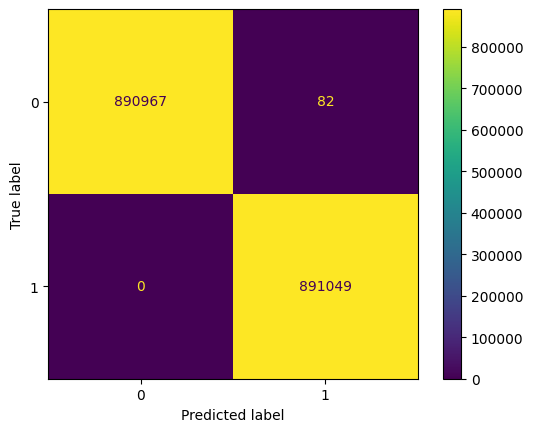

In [21]:
ConfusionMatrixDisplay(train_matrix).plot()
plt.show()

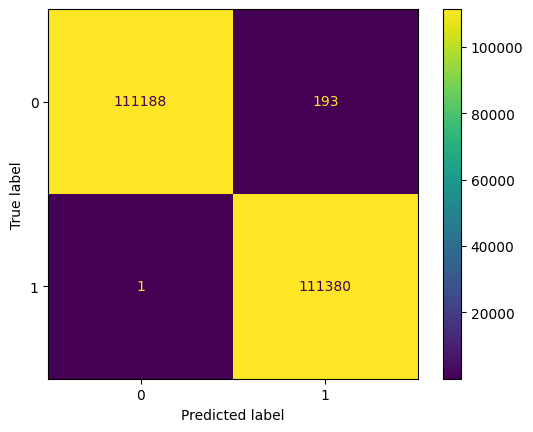

In [22]:
ConfusionMatrixDisplay(valid_matrix).plot()
plt.show()

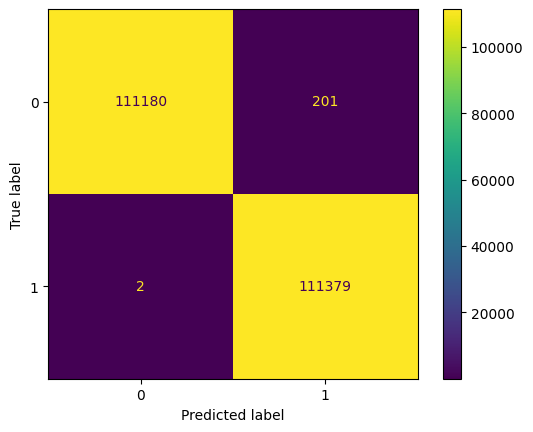

In [23]:
ConfusionMatrixDisplay(test_matrix).plot()
plt.show()

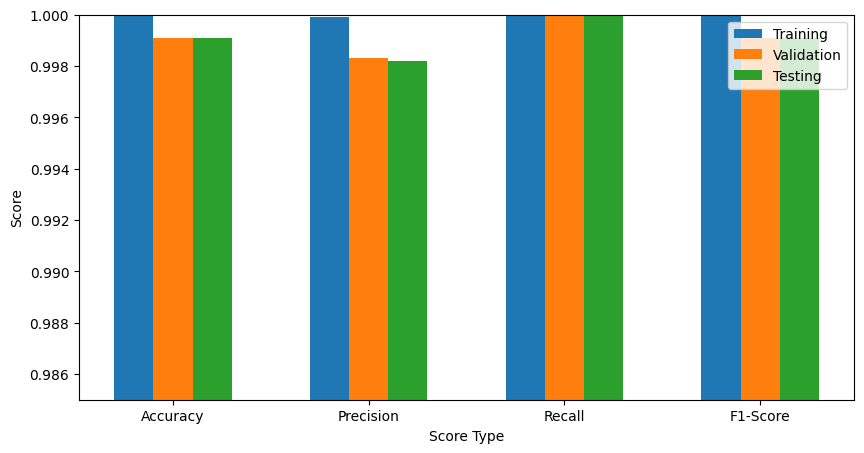

In [24]:
types = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(types))
plt.figure(figsize = (10, 5))

train_scores = [np.round(train_acc, 4), np.round(train_prec, 4), np.round(train_rec, 4), np.round(train_f1, 4)]
valid_scores = [np.round(valid_acc, 4), np.round(valid_prec, 4), np.round(valid_rec, 4), np.round(valid_f1, 4)]
test_scores = [np.round(test_acc, 4), np.round(test_prec, 4), np.round(test_rec, 4), np.round(test_f1, 4)]

# Create a bar plot
plt.bar(x - 0.2, train_scores, width = 0.2, label='Training')
plt.bar(x, valid_scores, width = 0.2, label='Validation')
plt.bar(x + 0.2, test_scores, width = 0.2, label='Testing')
plt.xticks(x, types)
y_min, y_max = plt.ylim()
plt.ylim(0.985, 1)
plt.xlabel('Score Type')
plt.ylabel('Score')

plt.legend(loc = "upper right")
plt.show()

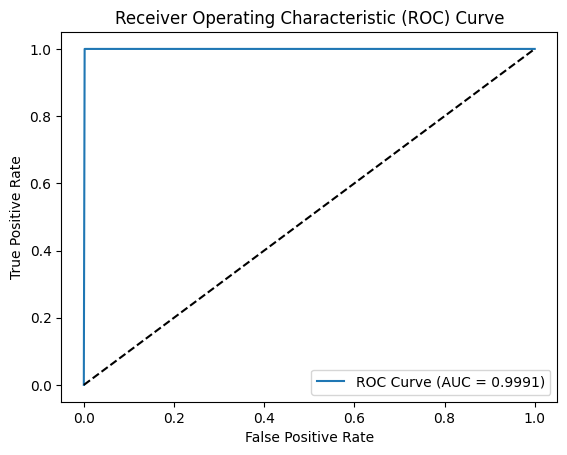

In [25]:
fpr, tpr, thresholds = roc_curve(test_y, test_pred)
auc_score = roc_auc_score(test_y, test_pred)
plt.plot(fpr, tpr, label = 'ROC Curve (AUC = %0.4f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc = 'lower right')
plt.show()

In [26]:
import pickle
with open('predictor.pkl', 'wb') as f:
    pickle.dump(model, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)